<a id='К_оглавлению'></a>
## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Необходимо

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделайть тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### Разделим данное исследование на несколько частей
* [Подготовка данных](#Подготовка_данных)
* [Анализ](#Анализ)
* [Обучение](#Обучение)
* [Тестирование модели](#Тестирование_модели)

<a id='Подготовка_данных'></a>
# 1. Подготовка
Загрузим необходимые бибилиотеки и изучим данные.

In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [2]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Убедимся, что индекс стоит в правильном порядке, а так же изменим интервал на часовой.

In [4]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [5]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


[К оглавлению](#К_оглавлению)
<a id='Анализ'></a>
# 2. Анализ

Посмотрим на гистограму таблицы.

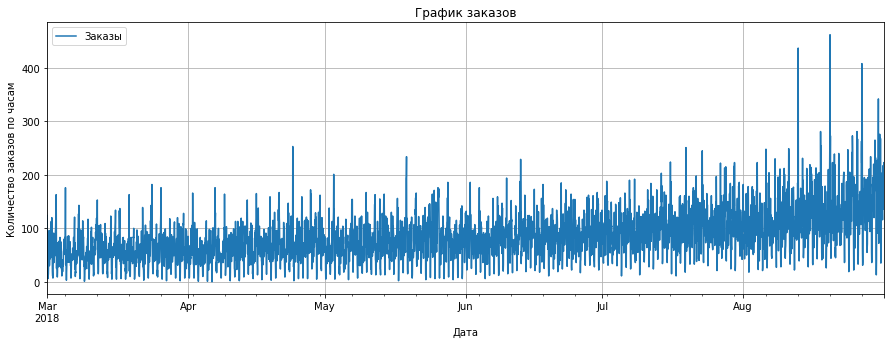

In [6]:
df.plot(figsize=(15,5),grid=True)
plt.xlabel('Дата')
plt.ylabel('Количество заказов по часам')
plt.title('График заказов')
plt.legend(['Заказы'])
plt.show()

На графике представлен нестационарный ряд в котором присутствует сезонность. Рассмотрим график по месяцам, что бы убедиться в этом.

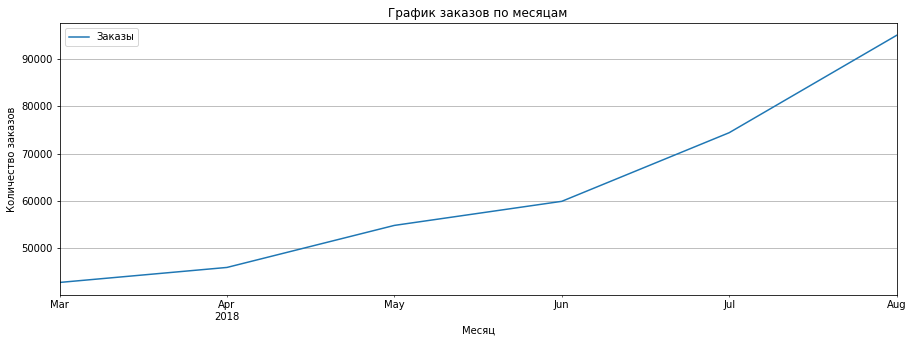

In [7]:
df.resample('1M').sum().plot(figsize=(15,5),grid=True)
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('График заказов по месяцам')
plt.legend(['Заказы'])
plt.show()

Количество заказов резко возрастает в летний период, что говорит о сезоне отпусков. Так же посмотрим на скользящее среднее значение и отклонение.

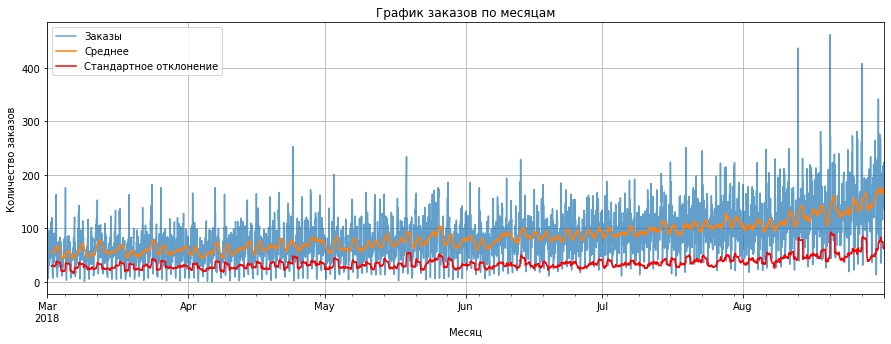

In [8]:
df.plot(figsize=(15,5),grid=True, alpha=0.7)
df['num_orders'].rolling(25).mean().plot(grid=True)
df['num_orders'].rolling(25).std().plot(grid=True, color='r')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('График заказов по месяцам')
plt.legend(['Заказы','Среднее','Стандартное отклонение'])
plt.show()

До июня график менее стабилен. Скорее потому, что спрос на туризм падает в виду окончания зимнего сезона. С начала лета график начинает стабильно расти. И только в вавгусте имеются выбросы.

[К оглавлению](#К_оглавлению)
<a id='Обучение'></a>
# 3. Обучение
Создадим признаки для обучения м подберем отстающие значения и щирину окна.

In [9]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 23, 10)

In [10]:
df.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборку, а так же избавимся от пропущенных значений.

In [11]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Убедимся, что таблица разделена правильно и конец обучающей выборки продолжает тестовая.

In [12]:
features_train.index

DatetimeIndex(['2018-03-01 23:00:00', '2018-03-02 00:00:00',
               '2018-03-02 01:00:00', '2018-03-02 02:00:00',
               '2018-03-02 03:00:00', '2018-03-02 04:00:00',
               '2018-03-02 05:00:00', '2018-03-02 06:00:00',
               '2018-03-02 07:00:00', '2018-03-02 08:00:00',
               ...
               '2018-08-13 04:00:00', '2018-08-13 05:00:00',
               '2018-08-13 06:00:00', '2018-08-13 07:00:00',
               '2018-08-13 08:00:00', '2018-08-13 09:00:00',
               '2018-08-13 10:00:00', '2018-08-13 11:00:00',
               '2018-08-13 12:00:00', '2018-08-13 13:00:00'],
              dtype='datetime64[ns]', name='datetime', length=3951, freq='H')

In [13]:
features_test.index

DatetimeIndex(['2018-08-13 14:00:00', '2018-08-13 15:00:00',
               '2018-08-13 16:00:00', '2018-08-13 17:00:00',
               '2018-08-13 18:00:00', '2018-08-13 19:00:00',
               '2018-08-13 20:00:00', '2018-08-13 21:00:00',
               '2018-08-13 22:00:00', '2018-08-13 23:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=442, freq='H')

Для обучения я буду использовать кросс-валидацию для того, что бы сохранить очередность данных загрузим *TimeSeriesSplit*.

In [14]:
tscv = TimeSeriesSplit(n_splits=3)

Подберем параметры для сеткок и обучим модели.

**RandomForestRegressor**

In [15]:
forest_param = {
    'max_depth':[15, 30],
    'n_estimators': [120, 150]
}

In [16]:
rand_forest = RandomForestRegressor(random_state=42)
rand_grid_forest = GridSearchCV(estimator = rand_forest, param_grid=forest_param, cv=tscv, scoring='neg_mean_squared_error')

In [17]:
%%time
rand_grid_forest.fit(features_train, target_train)

CPU times: user 1min 13s, sys: 160 ms, total: 1min 13s
Wall time: 1min 15s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None

**LGBMRegressor**

In [18]:
lgbm_param_grid = {'num_leaves': [200, 300],
              'n_estimators': [120, 150],
              'max_depth': [10, 25],
                  'metric': ['rmse']}

In [19]:
lgbm = LGBMRegressor(random_state=42)
lgbm_grid_search = GridSearchCV(estimator = lgbm, param_grid=lgbm_param_grid, cv=tscv, scoring='neg_mean_squared_error')

In [20]:
%%time
lgbm_grid_search.fit(features_train, target_train)

CPU times: user 11min 16s, sys: 7.3 s, total: 11min 24s
Wall time: 11min 27s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 25], 'metric': ['rmse'],
                         'n_estimators': [12

**CatBoostRegressor**

In [21]:
cat_param = {
    'iterations': [300, 600],
    'depth': [5, 10]}

In [22]:
cat_model = CatBoostRegressor(verbose=500,early_stopping_rounds=50, 
                              random_state=42, loss_function='RMSE')
cat_grid_search = GridSearchCV(estimator = cat_model, param_grid=cat_param, cv=tscv, scoring='neg_mean_squared_error')

In [23]:
%%time
cat_grid_search.fit(features_train, target_train)

0:	learn: 28.9728508	total: 50.8ms	remaining: 15.2s
299:	learn: 14.7656688	total: 5.03s	remaining: 0us
0:	learn: 31.7012720	total: 5.33ms	remaining: 1.59s
299:	learn: 17.4611734	total: 7.62s	remaining: 0us
0:	learn: 33.5732487	total: 26.4ms	remaining: 7.89s
299:	learn: 19.5389141	total: 11.2s	remaining: 0us
0:	learn: 28.9728508	total: 3.46ms	remaining: 2.07s
500:	learn: 11.6513618	total: 7.84s	remaining: 1.55s
599:	learn: 10.5717828	total: 9.48s	remaining: 0us
0:	learn: 31.7012720	total: 4.13ms	remaining: 2.48s
500:	learn: 15.1351026	total: 12.2s	remaining: 2.41s
599:	learn: 14.2779778	total: 14.6s	remaining: 0us
0:	learn: 33.5732487	total: 9.98ms	remaining: 5.98s
500:	learn: 17.4898594	total: 18.9s	remaining: 3.73s
599:	learn: 16.6418110	total: 22.7s	remaining: 0us
0:	learn: 28.9745216	total: 116ms	remaining: 34.7s
299:	learn: 7.3063569	total: 38s	remaining: 0us
0:	learn: 31.6638011	total: 197ms	remaining: 58.8s
299:	learn: 10.1447500	total: 50.4s	remaining: 0us
0:	learn: 33.5294175	t

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f2dc576e4d0>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [5, 10], 'iterations': [300, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

## Вывод
Были созданы признаки для обучения, разделены данные на тестовую и валидационную выборки. Так же были созданы 3 можели и обучены с использованием кросс валидации.

[К оглавлению](#К_оглавлению)
<a id='Тестирование_модели'></a>
# 4. Тестирование
Автоматизируем построение графиков для моделей. и протестируем их качество.

In [24]:
def models_testing(name, model_name):
    
    print('RMSE:',mean_squared_error(target_test, name)**0.5)
    
    plt.figure(figsize=(19,7))
    sns.lineplot(data=target_test, color='green')
    sns.lineplot(x=target_test.index, y=name, color='red')
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.title('Отношение предсказаний к тестовой выборке ' + model_name)
    plt.grid()

RMSE: 46.044041678809705


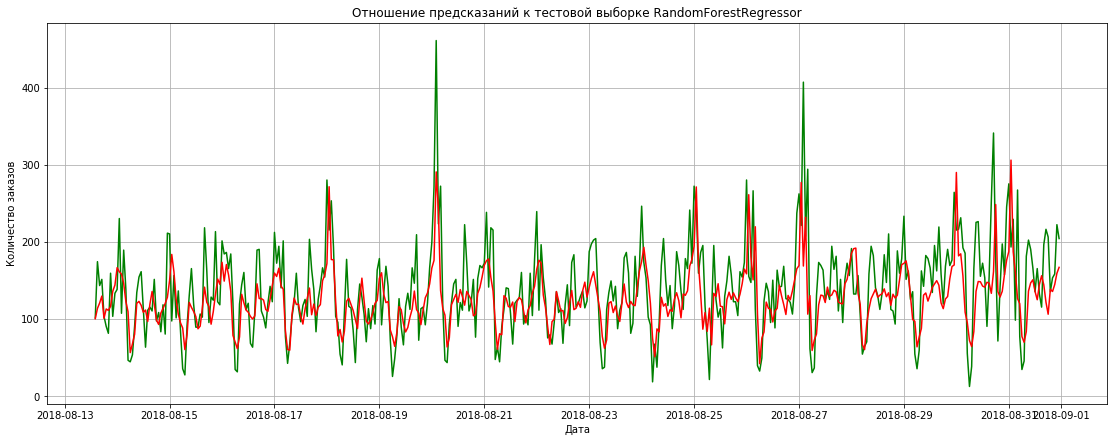

In [25]:
forest_pred = rand_grid_forest.predict(features_test)
models_testing(forest_pred,'RandomForestRegressor')

RMSE: 43.3170611621662


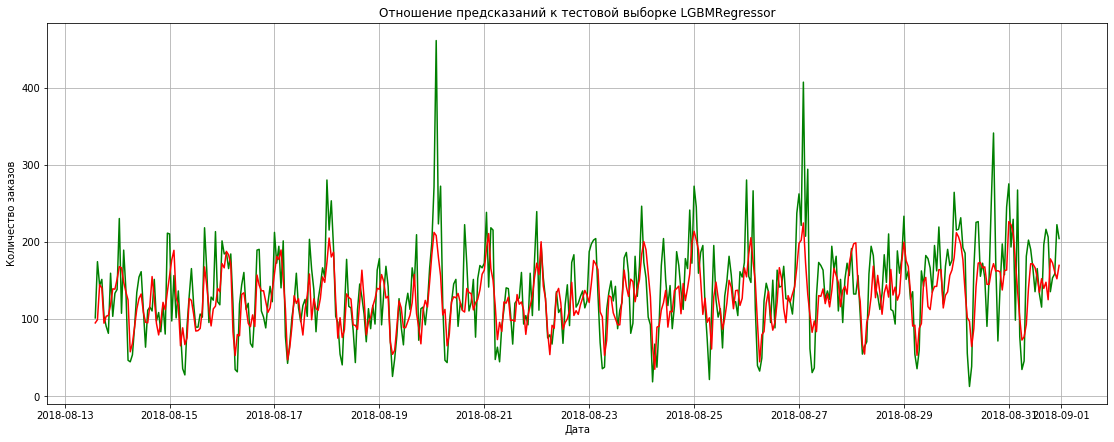

In [26]:
lgbm_pred = lgbm_grid_search.predict(features_test)
models_testing(lgbm_pred, 'LGBMRegressor')

RMSE: 44.86943667721718


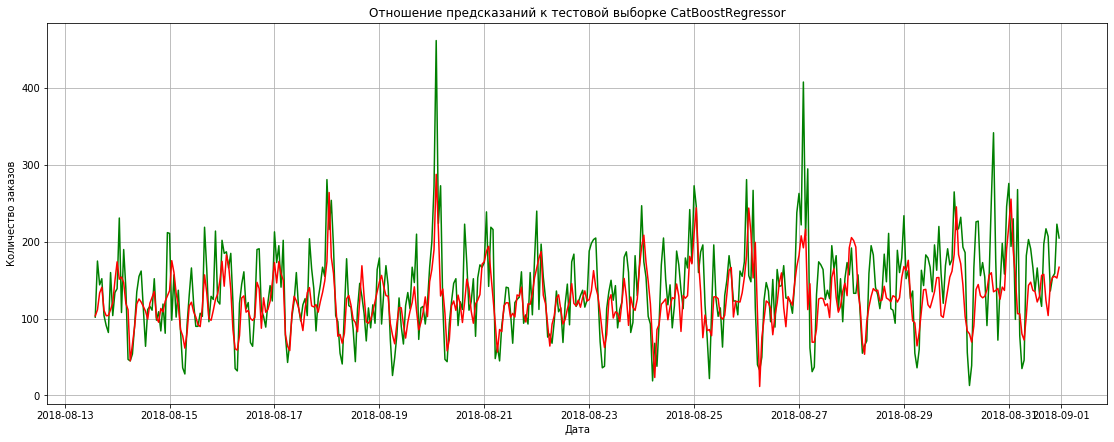

In [27]:
cat_pred = cat_grid_search.predict(features_test)
models_testing(cat_pred,'CatBoostRegressor')

In [28]:
pd.DataFrame({'RMSE':[mean_squared_error(target_test, forest_pred)**0.5,
                      mean_squared_error(target_test, lgbm_pred)**0.5,
                     mean_squared_error(target_test, cat_pred)**0.5],
             'Время':['1min 15s' ,'11min 27s', '9min 45s']}, 
             index=['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'])

,RMSE,Время
RandomForestRegressor,46.044042,1min 15s
LGBMRegressor,43.317061,11min 27s
CatBoostRegressor,44.869437,9min 45s


## Вывод 
Из всех представленных моделей лучший результат показал **LGBMRegressor** оне не так хорошо предсказывает выбросы как 
**RandomForestRegressor**, но его результаты ближе всего к искомым нам значениям. Если учитывать время, лучшее сочетание скорости и качетва является  **LGBMRegressor**.

[К оглавлению](#К_оглавлению)